In [1]:
import pandas as pd
import os
import cv2
import shutil
import numpy as np
import zipfile
import matplotlib.pyplot as plt
from google.colab import drive
from PIL import Image, ImageDraw
from sklearn.model_selection import train_test_split




In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
#paths for Smart
train = '/content/drive/MyDrive/sea_turtle_project_extracted/sea turtle project/Train.csv'
images = '/content/drive/MyDrive/sea_turtle_project_extracted/sea turtle project/IMAGES_512'
annotations = '/content/train/labels'
train_ims = '/content/train/images'
path = '/content/drive/MyDrive/sea_turtle_project_extracted/sea turtle project/IMAGES_512.zip'


In [ ]:
#Smart
# Path to the zip file
zip_file_path = '/content/drive/MyDrive/sea turtle project-20240423T085851Z-001.zip'

# Directory where you want to extract the files
extract_dir = '/content/drive/MyDrive/sea_turtle_project_extracted'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Extraction completed.")

In [3]:
train = '/content/drive/MyDrive/Datasets/sea turtle project/Train.csv'
images = '/content/drive/MyDrive/Datasets/sea turtle project/IMAGES_512'
annotations = '/content/train/labels'
train_ims = '/content/train/images'
path = '/content/drive/MyDrive/Datasets/sea turtle project/IMAGES_512.zip'

In [4]:
# Directory where you want to extract the files
extract_dir = '/content/drive/MyDrive/Datasets/sea turtle project'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Extraction completed.")

Extraction completed.


In [5]:
len(os.listdir(images))

2023

In [6]:
os.makedirs(annotations, exist_ok=True)
os.makedirs(train_ims, exist_ok=True)

In [7]:
def convert_to_yolo(csv_file, images_folder, output_folder_labels, output_folder_images):
    """
    Convert bounding box coordinates to YOLO format and save them to text files.

    Args:
        csv_file (str): Path to the CSV file containing bounding box coordinates.
        images_folder (str): Path to the folder containing the corresponding images.
        output_folder_labels (str): Path to the folder where YOLO label files will be saved.
        output_folder_images (str): Path to the folder where images will be moved after processing.

    Returns:
        None
    """
    df = pd.read_csv(csv_file)

    # Loop through each row in the dataset
    for index, row in df.iterrows():
        # Extract bounding box coordinates
        x, y, w, h = row["x"], row["y"], row["w"], row["h"]

        # Read image dimensions
        img_path = os.path.join(images_folder, f"{row['Image_ID']}.JPG")
        img = cv2.imread(img_path)
        image_height, image_width, _ = img.shape

        # Convert bounding box coordinates to YOLO format
        x_min = x * image_width
        y_min = y * image_height
        box_width = w * image_width
        box_height = h * image_height

        x_center = x_min + box_width / 2
        y_center = y_min + box_height / 2

        x_center /= image_width
        y_center /= image_height
        box_width /= image_width
        box_height /= image_height

        # Move image file
        shutil.move(img_path, os.path.join(output_folder_images, f"{row['Image_ID']}.JPG"))

        # Write label content to YOLO label file
        output_path = os.path.join(output_folder_labels, f"{row['Image_ID']}.txt")
        with open(output_path, 'w') as f:
            f.write(f"0 {x_center} {y_center} {box_width} {box_height}")


In [8]:

# Convert annotations to YOLO format and moving their corespondig images to train_ims directory using the convert_to_yolo function
convert_to_yolo(train, images, annotations,train_ims)

In [9]:
# Split data (images) into train and validation sets
image_files = os.listdir(train_ims)
train_images, validation_images = train_test_split(image_files, test_size=0.2, random_state=42)

In [10]:
# Defining paths for images and labels for the training and validation sets
t_images ="/content/train/train/images"
t_labels ="/content/train/train/labels"
val_images ="/content/train/validation/images"
val_labels ="/content/train/validation/labels"

In [11]:
# Creating directories / folders for images and labels for the training and validation sets
os.makedirs(t_images, exist_ok=True)
os.makedirs(t_labels, exist_ok=True)
os.makedirs(val_images, exist_ok=True)
os.makedirs(val_labels, exist_ok=True)

In [12]:
# Get the list of label files in the annotations folder
label_files = os.listdir(annotations)

# Get the list of image codes in the test and val folders
train_image_codes = [os.path.splitext(file)[0] for file in train_images]
val_image_codes = [os.path.splitext(file)[0] for file in validation_images]

# Move label files to train_label folder if image code matches
for label_file in label_files:
    image_code = os.path.splitext(label_file)[0]
    if image_code in train_image_codes:
        source_path = os.path.join(annotations, label_file)
        destination_path = os.path.join(t_labels, label_file)
        shutil.move(source_path, destination_path)

# Move label files to val_label folder if image code matches
for label_file in label_files:
    image_code = os.path.splitext(label_file)[0]
    if image_code in val_image_codes:
        source_path = os.path.join(annotations, label_file)
        destination_path = os.path.join(val_labels, label_file)
        shutil.move(source_path, destination_path)



In [13]:
# Moving image files to t_images folder from train_ims
for filename in train_images:
    image_path = os.path.join(train_ims, filename)
    shutil.move(image_path, t_images)

# Moving image files to val_images folder from train_ims
for filename in validation_images:
    image_path = os.path.join(train_ims, filename)
    shutil.move(image_path, val_images)


In [14]:
# Function which generates the yaml file
def generate_data_yaml(train_folder, test_folder, output_file):

   # Get class names from label files
   train_labels = os.listdir(os.path.join(train_folder, 'labels'))
   class_names = set()
   for label_file in train_labels:
       with open(os.path.join(train_folder, 'labels', label_file), 'r') as f:
           lines = f.readlines()
           for line in lines:
               class_idx = line.split()[0]
               class_names.add(class_idx)

   # Write data.yaml file
   with open(output_file, 'w') as f:
       f.write(f'train: {train_folder}\n')
       f.write(f'val: {test_folder}\n')
       f.write('nc: {}\n'.format(len(class_names)))
       f.write('names: ["head"]\n')

In [15]:
# Paths to train and validation folders
validation_folder = "/content/train/validation"
train_folder = "/content/train/train"

# Output file path
output_file = 'data.yaml'
# Generate data.yaml file
generate_data_yaml(train_folder, validation_folder, output_file)


In [ ]:
!cat /content/data.yaml

train: /content/train/train
val: /content/train/validation
nc: 1
names: ["head"]


In [16]:
# Installing YoloV8 model

!pip install ultralytics==8.0.28

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.28 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 29.1/78.2 GB disk)


In [17]:
# Importing the YOLO model
from ultralytics import YOLO

In [18]:
# Instantiating the model
model = YOLO("yolov8s.pt")

100%|██████████| 21.5M/21.5M [00:00<00:00, 240MB/s]


In [19]:
# Training the model
results = model.train(data="/content/data.yaml",epochs=50,imgsz=512)

Ultralytics YOLOv8.0.28 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8s.yaml, data=/content/data.yaml, epochs=50, patience=50, batch=16, imgsz=512, save=True, cache=False, device=, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=False, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=17,

**Model Evalustion**

In [20]:
from IPython.display import Image

In [21]:
# cm
confusion_matrix_path = "/content/runs/detect/train/confusion_matrix.png"

# training curves
results_png_path = "/content/runs/detect/train/results.csv"

# val_batch0_prediction
val_batch0_pred_path = "/content/runs/detect/train/val_batch0_pred.jpg"

In [22]:
# val_batch1_prediction
val_batch1_pred_path = "/content/runs/detect/train/val_batch1_pred.jpg"

In [23]:
# val_batch2_prediction
val_batch2_pred_path = "/content/runs/detect/train/val_batch2_pred.jpg"

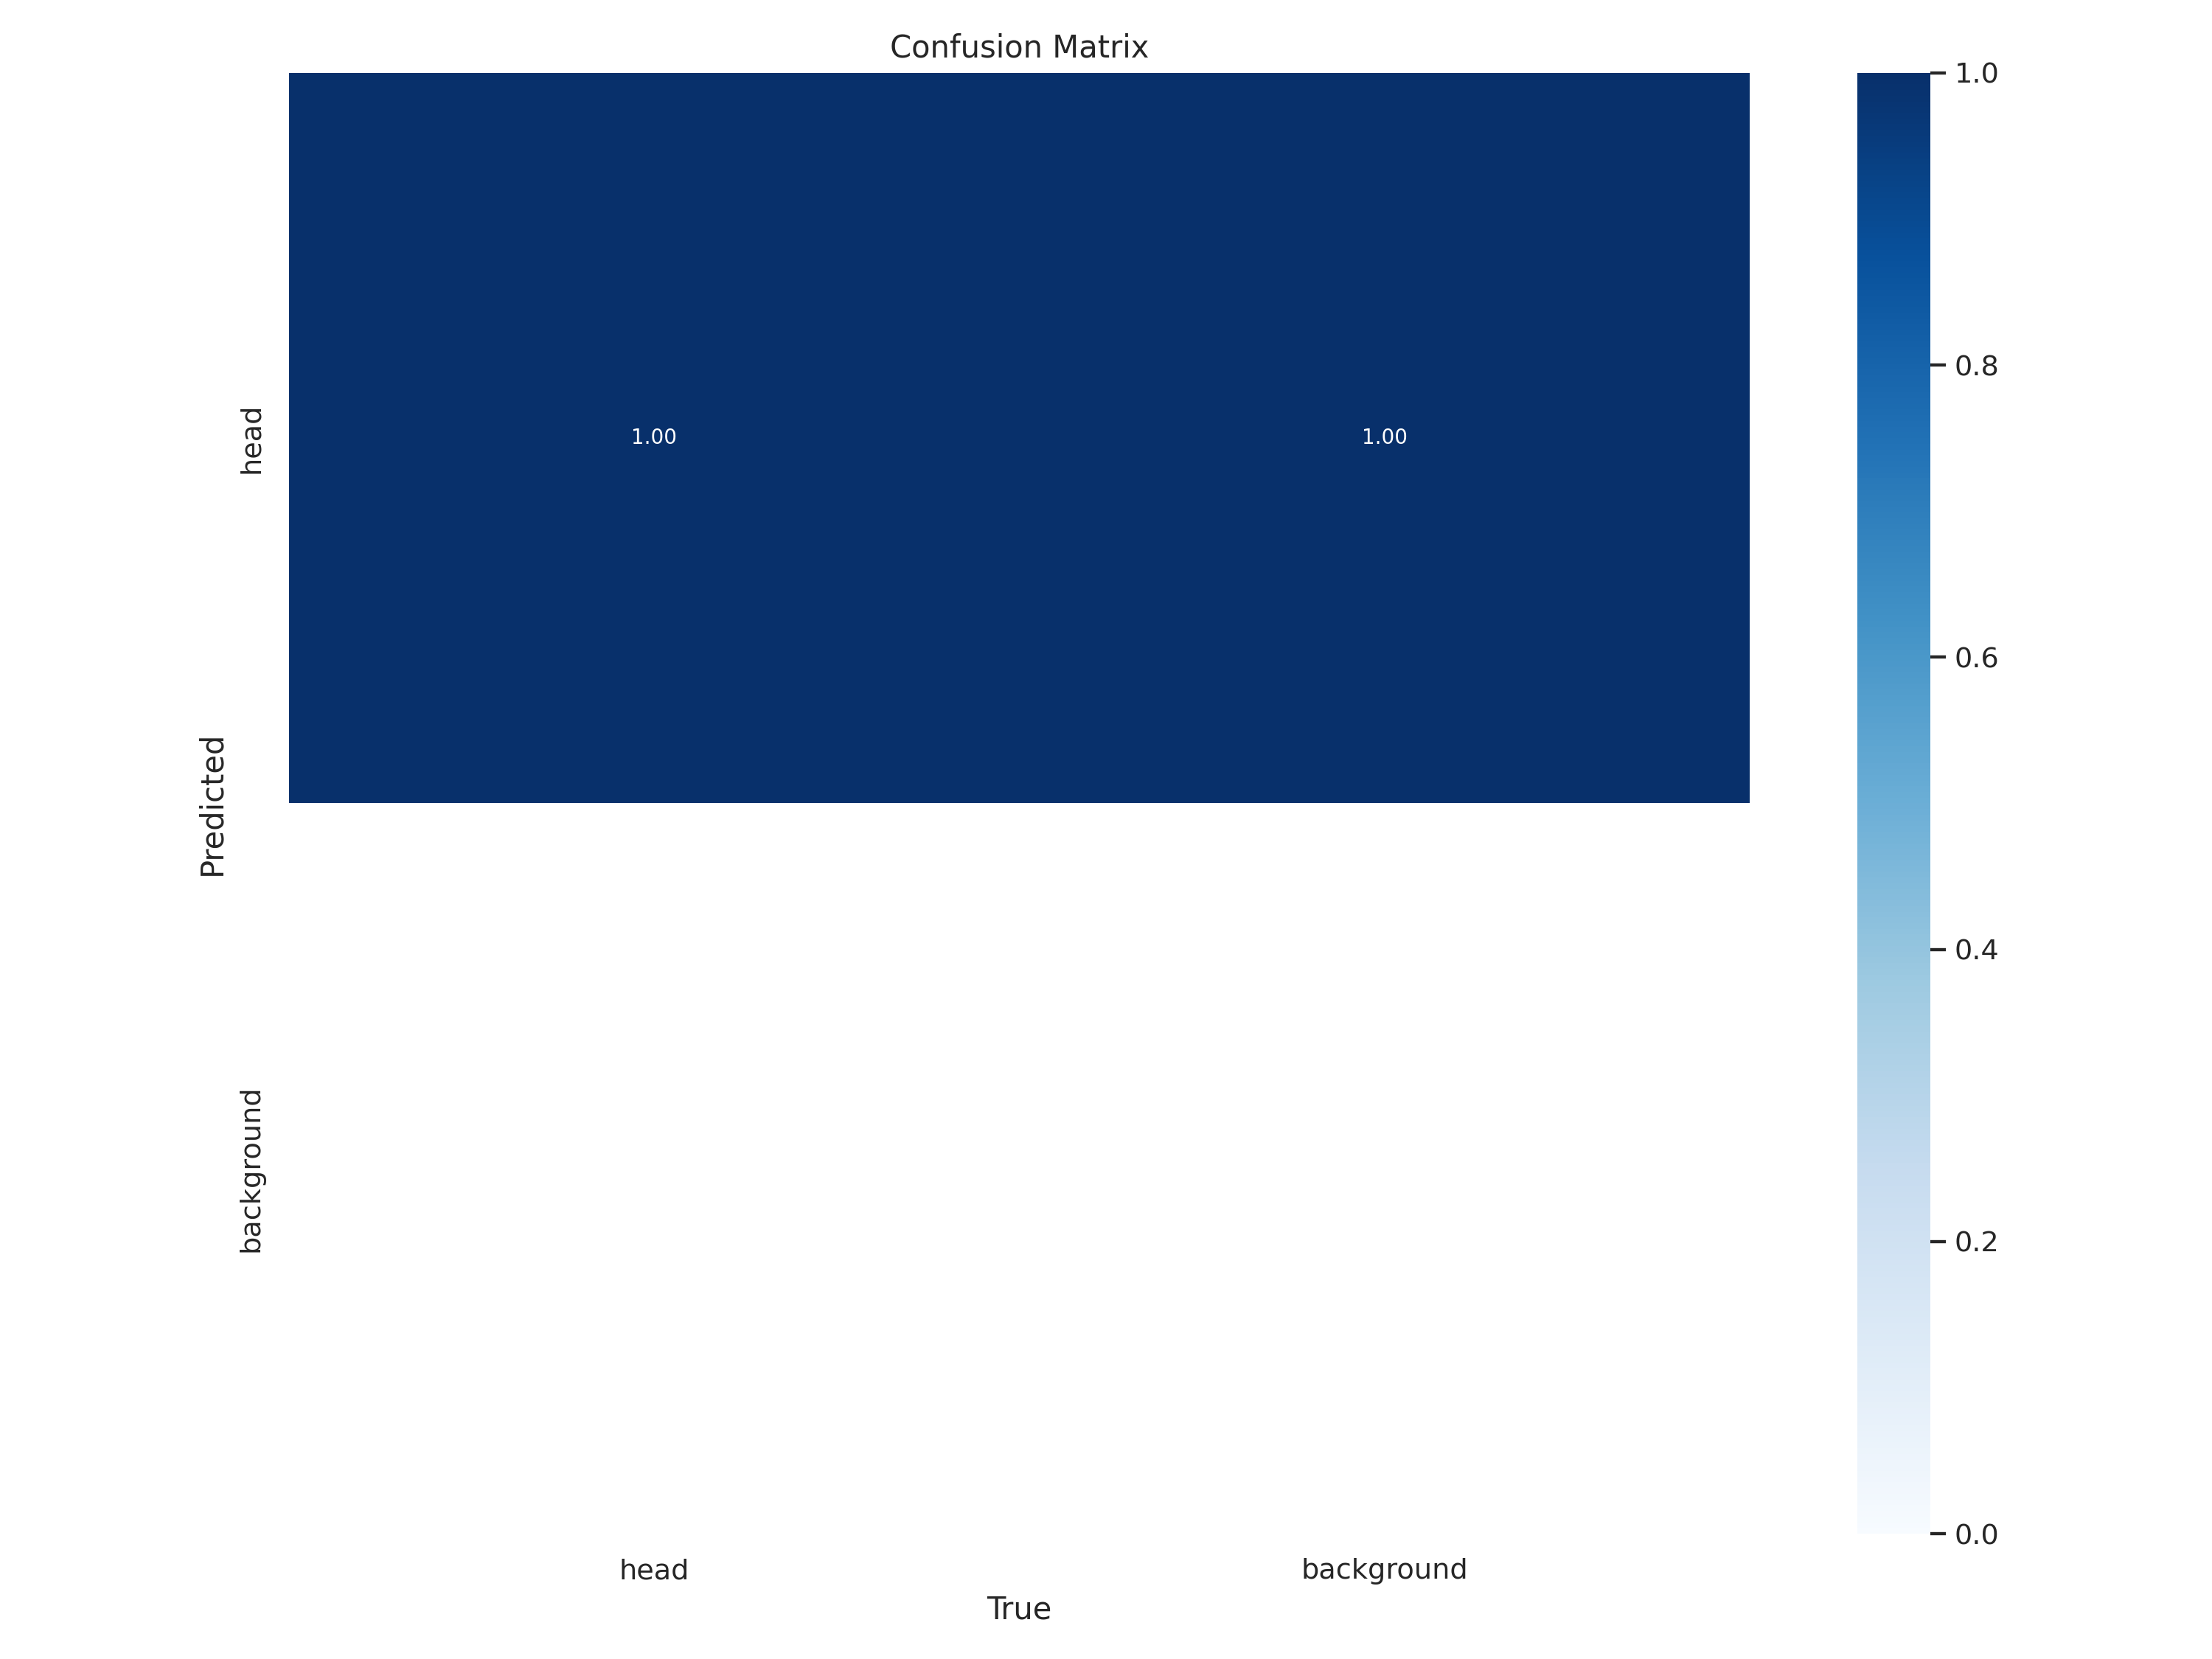

In [24]:
# confusion matrix
Image(filename=confusion_matrix_path, width=800)

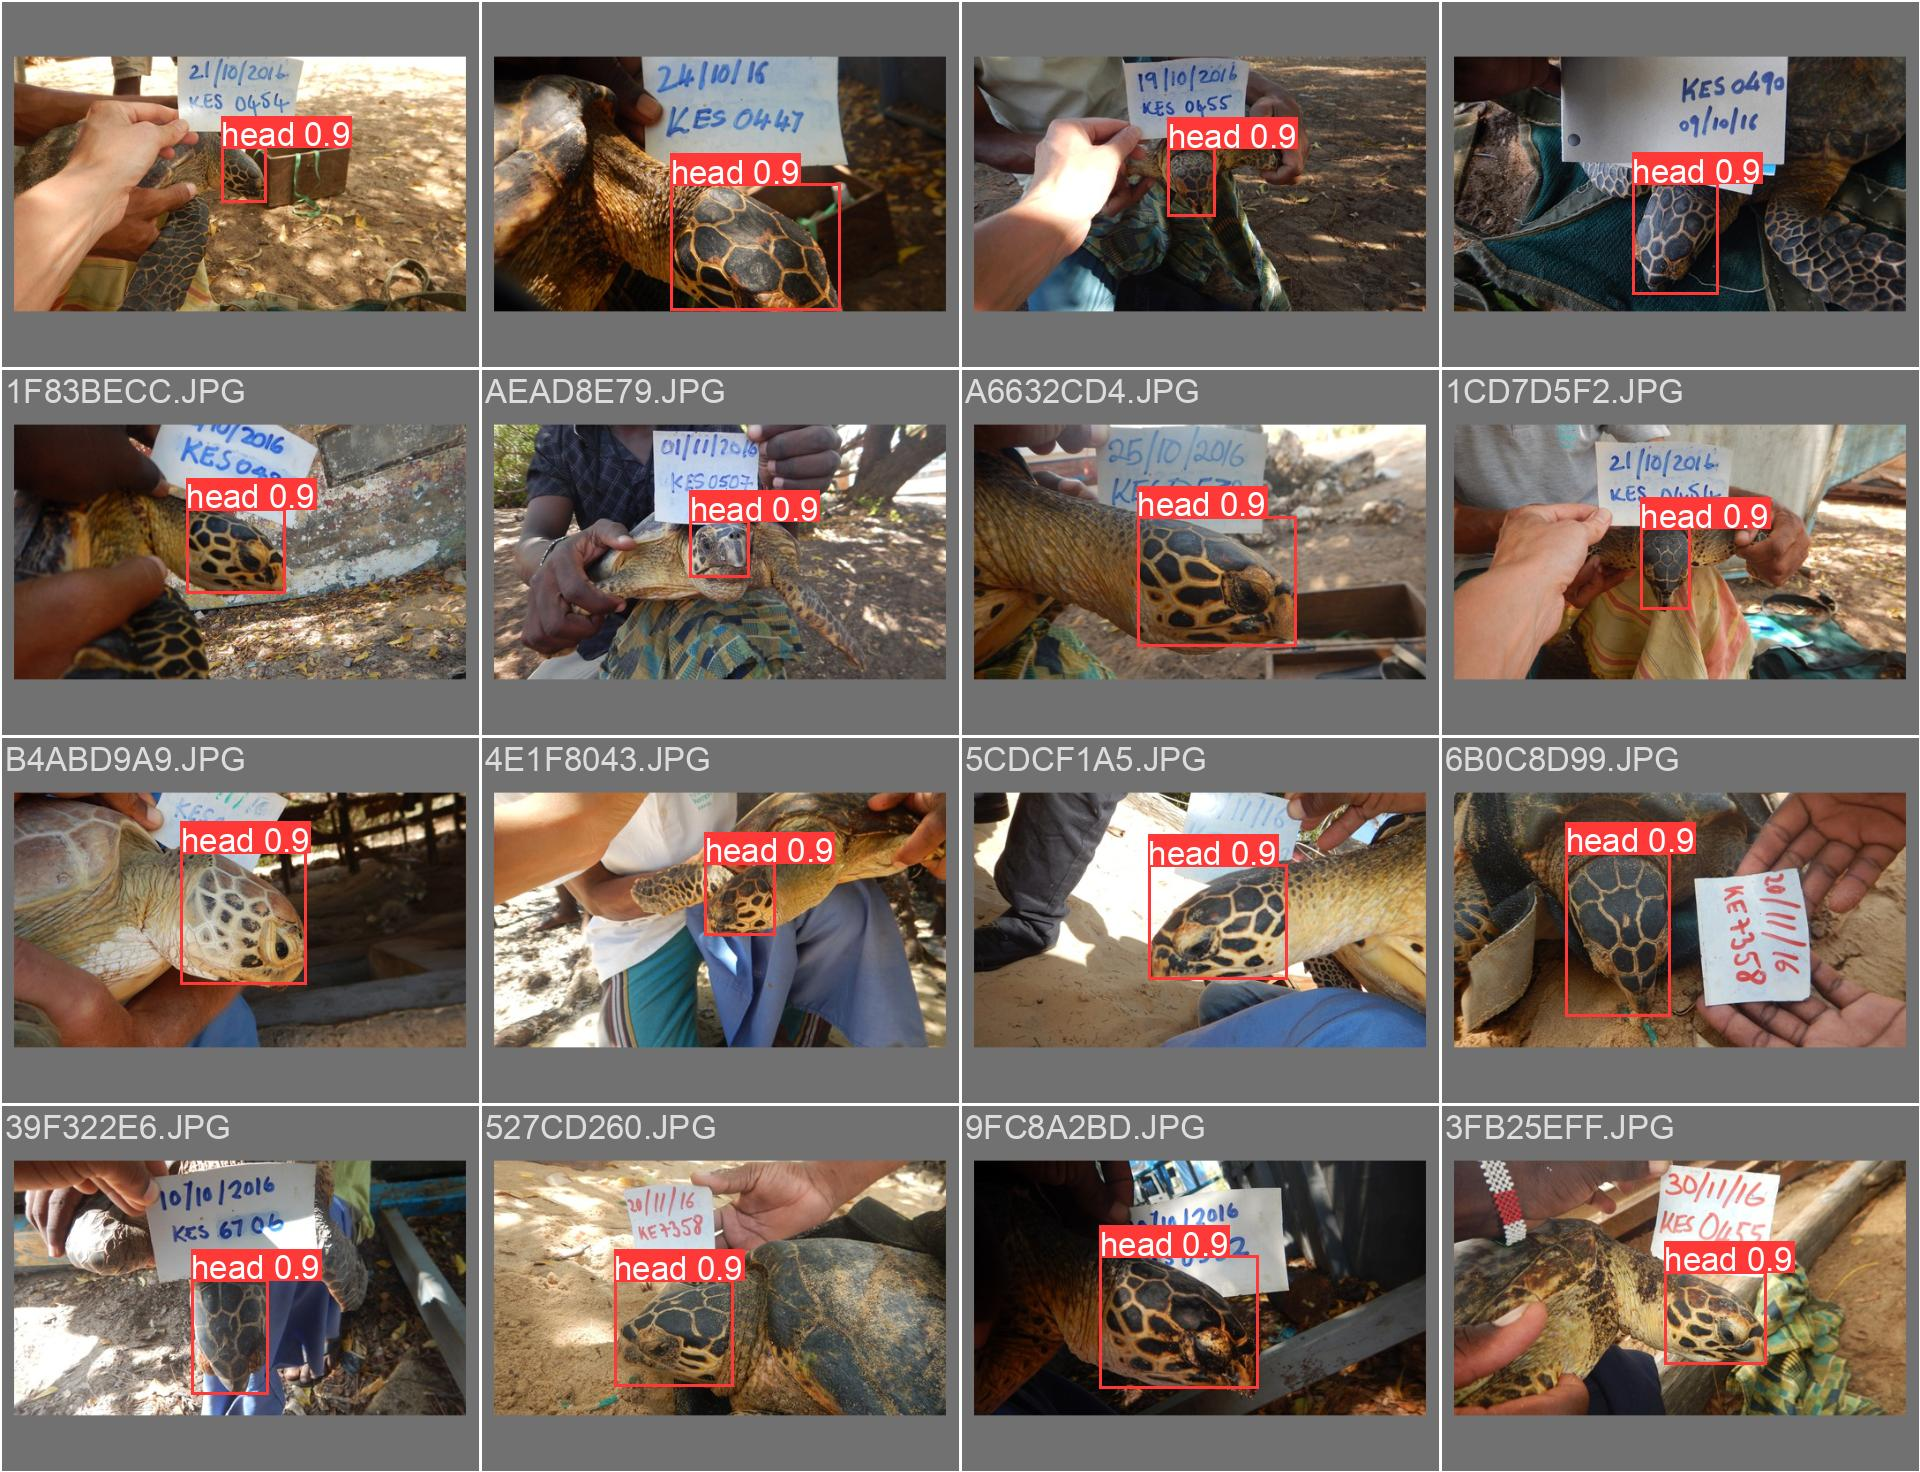

In [25]:
# val_batch0_pred
Image(filename=val_batch0_pred_path, width=800)

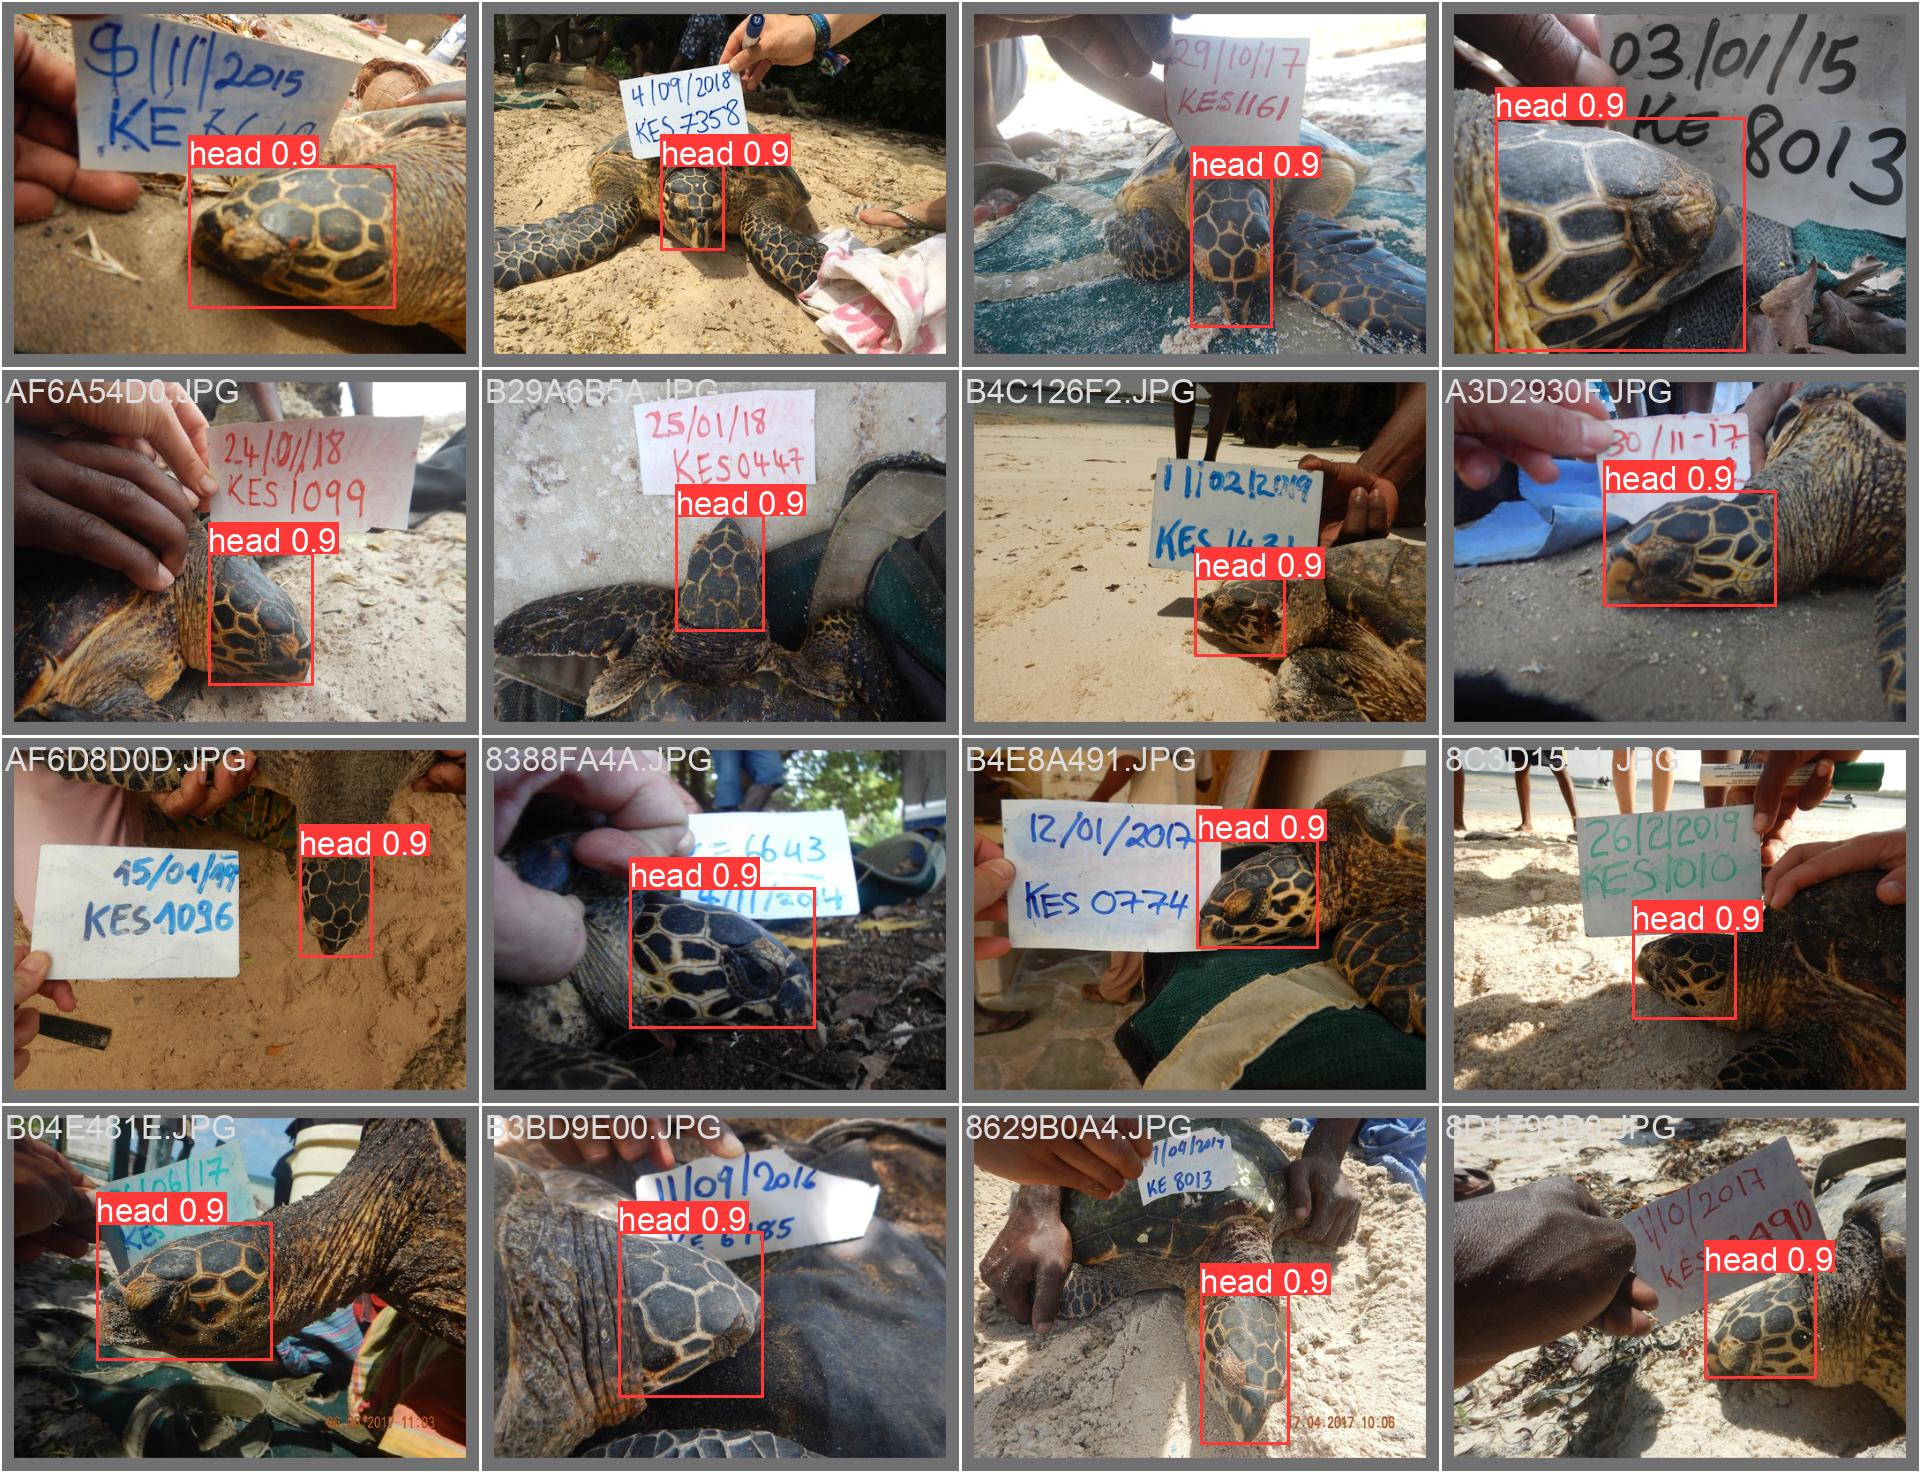

In [26]:
# val_batch1_pred
Image(filename=val_batch1_pred_path, width=800)

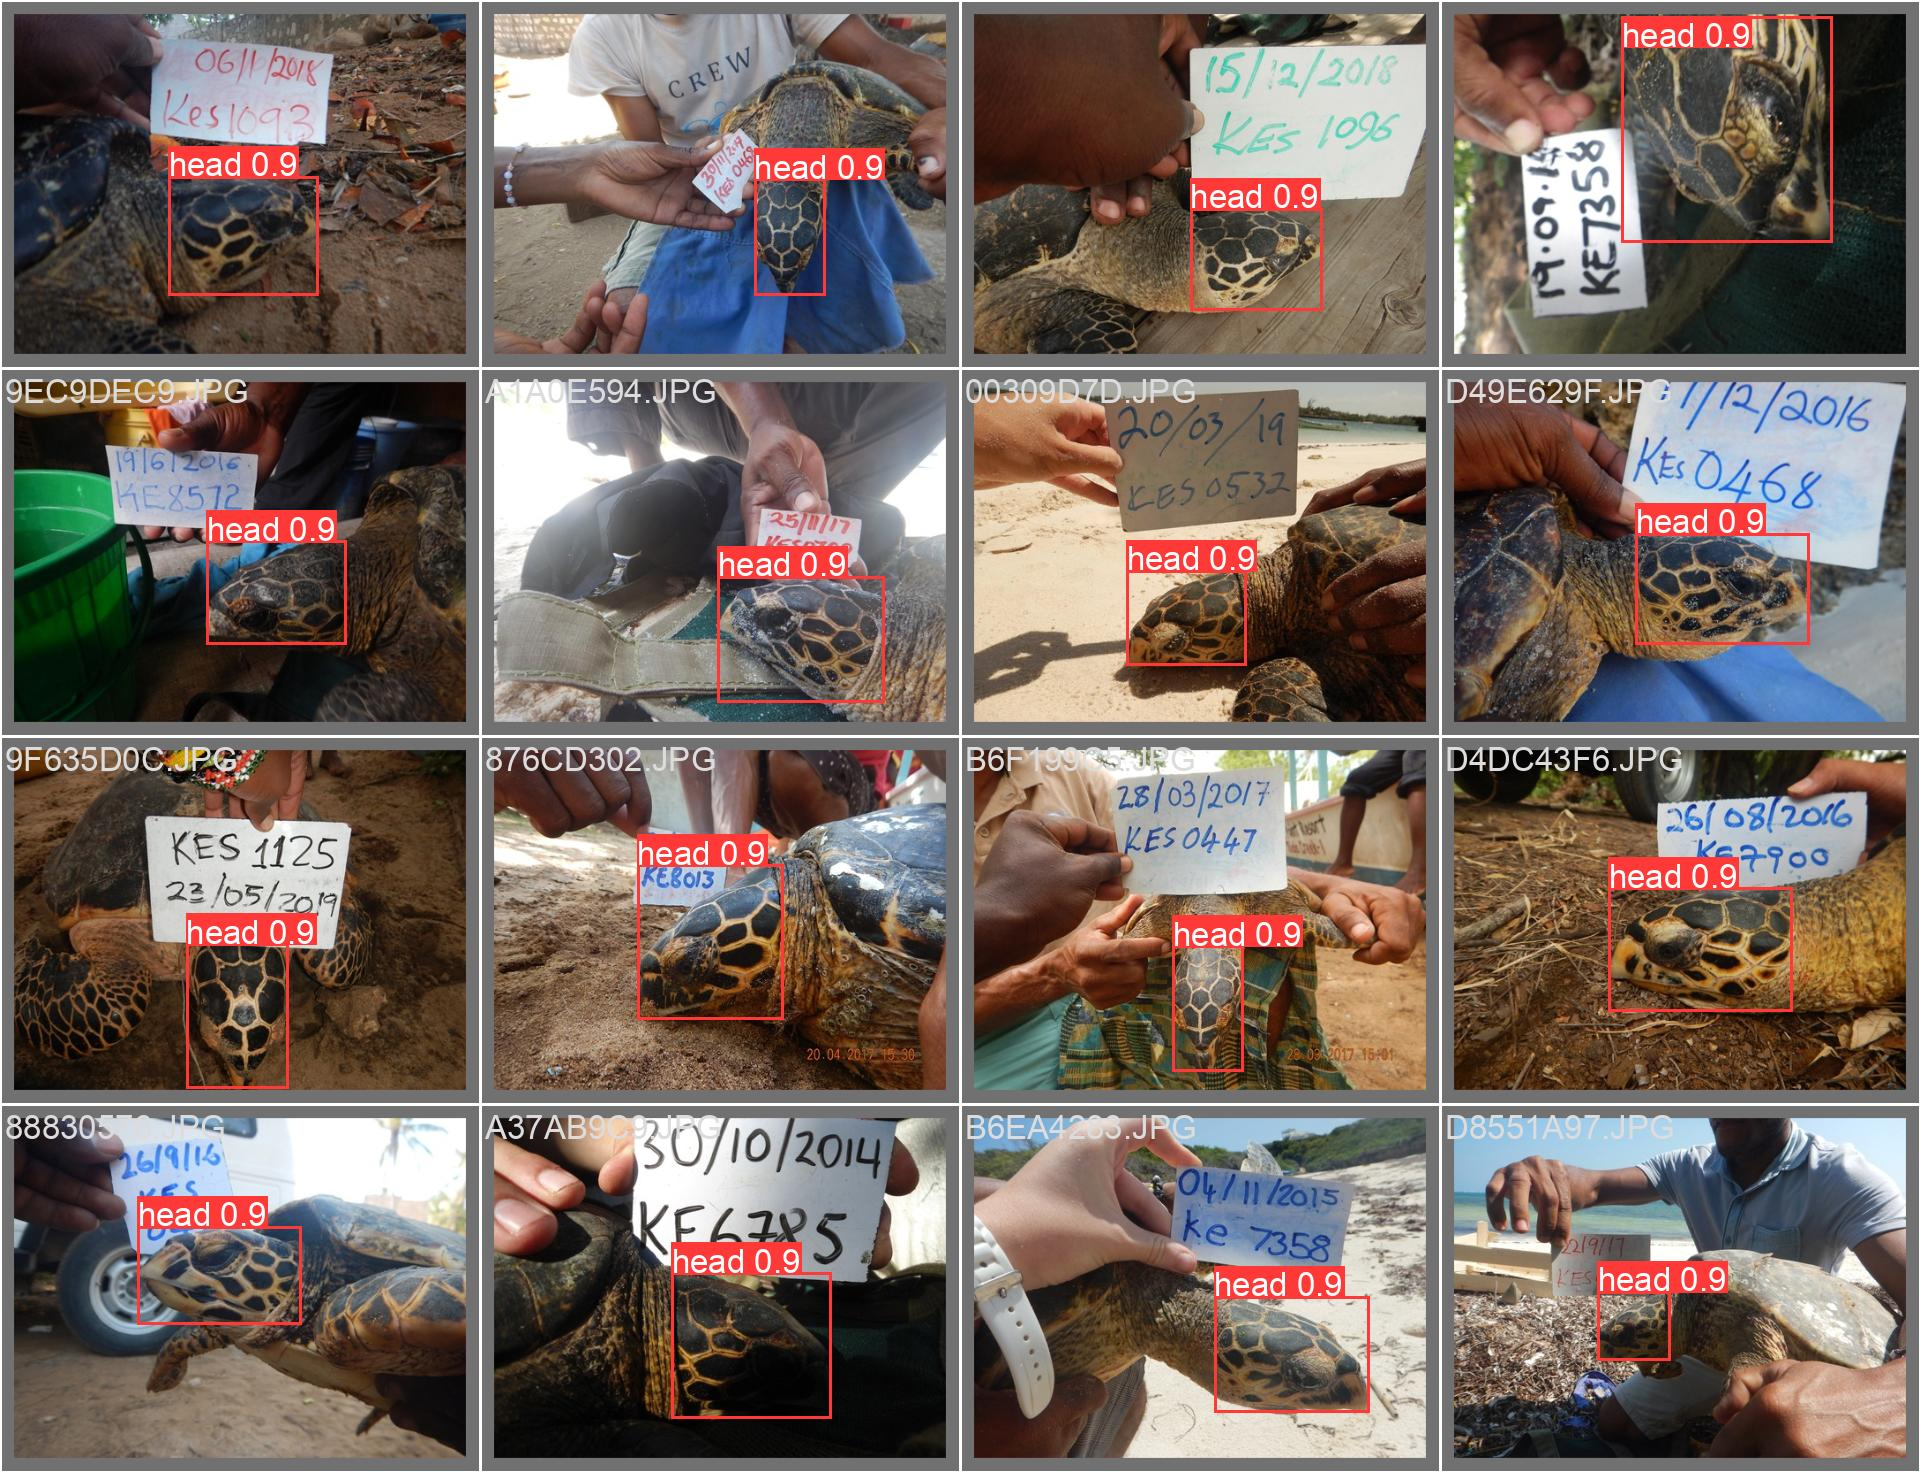

In [27]:
# val_batch2_pred
Image(filename=val_batch2_pred_path, width=800)

In [28]:
# location of the YOLO model weights
model_weights = '/content/runs/detect/train/weights/best.pt'

In [29]:
# images folder currently has only test images
len(os.listdir(images))

697

In [30]:
# Define the paths to the folders
test_images_folder = '/content/test/images'
test_image_labels = '/content/test/labels'

os.makedirs(test_images_folder, exist_ok=True)
os.makedirs(test_image_labels, exist_ok=True)

# Test image files
test_files = os.listdir(images)

# Move the test files to the test_images folder
for file in test_files:
    source = os.path.join(images, file)
    destination = os.path.join(test_images_folder, file)
    shutil.move(source, destination)

In [31]:
import subprocess

# Set the locale to UTF-8
env = os.environ.copy()
env['LC_ALL'] = 'en_US.UTF-8'
env['LANG'] = 'en_US.UTF-8'


In [32]:
# Define the YOLO command
command = 'yolo task=detect mode=predict model=/content/runs/detect/train/weights/best.pt conf=0.75 source=/content/test/images save_txt=true save_conf=true'


# Execute the YOLO command using subprocess
process = subprocess.Popen(command.split(), stdout=subprocess.PIPE, stderr=subprocess.PIPE, env=env)
output, error = process.communicate()


# Print output and error messages
print(output.decode('utf-8'))
print(error.decode('utf-8'))



2024-05-05 09:08:06.287063: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-05 09:08:06.287115: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-05 09:08:06.288592: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-05 09:08:07.479933: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Ultralytics YOLOv8.0.28 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs

WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/697 /content/test/ima

In [33]:
sample = pd.read_csv("/content/drive/MyDrive/Datasets/sea turtle project/SampleSubmission.csv")

In [34]:
sample.head()

,Image_ID,x,y,w,h
0,4863D911,0,0,0,0
1,6DD3ADD5,0,0,0,0
2,E8DC4D6A,0,0,0,0
3,E02ABB6C,0,0,0,0
4,875C19F4,0,0,0,0


In [35]:

def convert_to_xywh(csv_file, images_folder, output_folder_labels, output_folder_images):
    # Read the predictions from the CSV file
    df = pd.read_csv(csv_file)

    # Loop through each prediction
    for index, row in df.iterrows():
        image_id = row["Image_ID"]  # Get the Image_ID for the current row
        x_center, y_center = row["x_center"], row["y_center"]  # Extract predicted center coordinates
        box_width, box_height = row["box_width"], row["box_height"]  # Extract predicted box dimensions

        # Read image dimensions
        img_path = os.path.join(images_folder, f"{image_id}.JPG")
        img = cv2.imread(img_path)
        image_height, image_width, _ = img.shape

        # Denormalize coordinates and dimensions
        x_min = (x_center - box_width / 2) * image_width
        y_min = (y_center - box_height / 2) * image_height
        w = box_width * image_width
        h = box_height * image_height

        # Write the denormalized bounding box coordinates to the label file
        output_path = os.path.join(output_folder_labels, f"{image_id}.txt")
        with open(output_path, 'w') as f:
            f.write(f"{x_min} {y_min} {w} {h}")

        # Move the corresponding image to the output folder
        shutil.move(os.path.join(images_folder, f"{image_id}.JPG"), os.path.join(output_folder_images, f"{image_id}.JPG"))


In [36]:
import csv

# Path to the labels folder
labels_folder = '/content/runs/detect/predict/labels'
images_folder = "/content/runs/detect/predict"

# Path to save the CSV file
output_csv_file = '/content/output.csv'

# Function to parse YOLO label content and extract x, y, w, h
def parse_yolo_label(label_content):
    parts = label_content.strip().split(' ')
    class_id = parts[0]
    x_center = float(parts[1])
    y_center = float(parts[2])
    box_width = float(parts[3])
    box_height = float(parts[4])
    return x_center, y_center, box_width, box_height

# Function to convert YOLO label to x, y, w, h format
def convert_to_xywh(label_path):
    # Extract image_id from file name
    image_id = os.path.splitext(os.path.basename(label_path))[0]

    # Read YOLO label content
    with open(label_path, 'r') as f:
        label_content = f.read()

    # Parse YOLO label content
    x_center, y_center, box_width, box_height = parse_yolo_label(label_content)

    # Calculate x, y, w, h
    # Read image dimensions
    img_path = os.path.join(images_folder, f"{image_id}.JPG")
    img = cv2.imread(img_path)
    image_height, image_width, _ = img.shape

    # Denormalize coordinates and dimensions
    x_min = (x_center - box_width / 2) * image_width
    y_min = (y_center - box_height / 2) * image_height
    w = box_width * image_width
    h = box_height * image_height

    return image_id, x_min, y_min, w, h

# Write parsed data to CSV file
with open(output_csv_file, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['Image_ID', 'x', 'y', 'w', 'h'])  # Write header

    # Iterate over each .txt file in the labels folder
    for label_file in os.listdir(labels_folder):
        if label_file.endswith('.txt'):
            label_path = os.path.join(labels_folder, label_file)
            image_id, x, y, w, h = convert_to_xywh(label_path)
            csv_writer.writerow([image_id, x, y, w, h])


In [37]:
output = pd.read_csv("/content/output.csv")

In [38]:
output.head()

,Image_ID,x,y,w,h
0,50F03E04,198.000128,162.000000,65.999872,49.999872
1,84F86E8C,196.999936,113.999808,159.000064,137.000064
2,87878214,206.000128,162.999936,129.999872,106.000128
3,BA75D17B,188.999936,132.000000,160.999936,227.000064
4,875EFBC9,216.000256,187.999872,72.000000,108.000000


In [39]:
from PIL import Image, ImageDraw


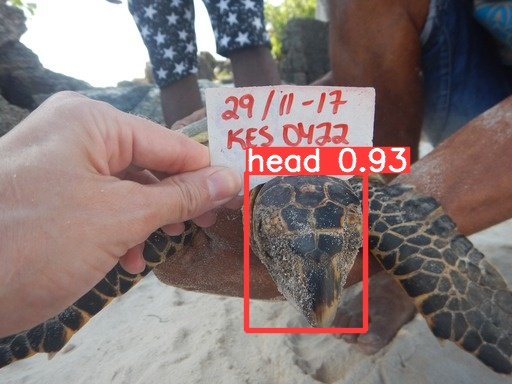

In [42]:
# Take a sample row
imid, x, y, w, h = output.sample().values[0]

# Open with PIL and draw a bounding box
with Image.open(f'{images_folder}/{imid}.JPG') as im:
  imw, imh = im.size # Box coords are relative to image size
  draw = ImageDraw.Draw(im)
  draw.rectangle([int(x*imw), int(y*imh), int((x+w)*imw), int((y+h)*imh)], width=2)
im

In [43]:
sample.head()


,Image_ID,x,y,w,h
0,4863D911,0,0,0,0
1,6DD3ADD5,0,0,0,0
2,E8DC4D6A,0,0,0,0
3,E02ABB6C,0,0,0,0
4,875C19F4,0,0,0,0


In [44]:
len(sample)

695

In [45]:

# Merge the two DataFrames based on the common 'Image_ID' column
merged_df = pd.merge(sample, output, on='Image_ID', how="left", suffixes=('_sample', '_output'))

# Replace values of 'x', 'y', 'w', and 'h' in the 'Sample' DataFrame with values from 'Output' DataFrame
merged_df['x_sample'] = merged_df['x_output']
merged_df['y_sample'] = merged_df['y_output']
merged_df['w_sample'] = merged_df['w_output']
merged_df['h_sample'] = merged_df['h_output']

# Replace missing values in sample dataframe with 0
merged_df['x_sample'] = merged_df['x_output'].fillna(0)
merged_df['y_sample'] = merged_df['y_output'].fillna(0)
merged_df['w_sample'] = merged_df['w_output'].fillna(0)
merged_df['h_sample'] = merged_df['h_output'].fillna(0)

# Drop unnecessary columns
merged_df = merged_df.drop(columns=['x_output', 'y_output', 'w_output', 'h_output'])

# Final DataFrame with replaced values
final_df = merged_df[['Image_ID', 'x_sample', 'y_sample', 'w_sample', 'h_sample']]
final_df.rename(columns={"x_sample":"x","y_sample":"y","w_sample":"w","h_sample":"h"}, inplace=True)

print(final_df)


     Image_ID           x           y           w           h
0    4863D911   89.999872  116.000064  298.999808  198.000000
1    6DD3ADD5  170.999808  115.999872  188.000256  189.000192
2    E8DC4D6A  186.000128  204.000192  224.999936  163.999872
3    E02ABB6C  168.999936  205.999872  215.000064  156.999936
4    875C19F4  188.999936  178.999872  205.000192  161.000064
..        ...         ...         ...         ...         ...
690  1E9E94E9  283.000320  138.999936   58.999808   85.999872
691  0EC294FB  264.000000  246.999936   83.999744  132.000000
692  888F7FF4  244.999936  189.999936   93.000192  162.999936
693  5A63FD0E  228.999936  243.000192  160.999936  120.999936
694  AD30E9B2  213.000192  211.000128  104.999936  149.000064

[695 rows x 5 columns]


In [46]:
final_df.head()

,Image_ID,x,y,w,h
0,4863D911,89.999872,116.000064,298.999808,198.000000
1,6DD3ADD5,170.999808,115.999872,188.000256,189.000192
2,E8DC4D6A,186.000128,204.000192,224.999936,163.999872
3,E02ABB6C,168.999936,205.999872,215.000064,156.999936
4,875C19F4,188.999936,178.999872,205.000192,161.000064


In [47]:

# Initialize an empty list to store rows of the final dataframe
final_data = []

# Loop through each row in the output dataframe
for index, row in final_df.iterrows():
    image_id = row["Image_ID"]  # Get the Image_ID for the current row
    x, y, w, h = row["x"], row["y"], row["w"], row["h"]  # Extract bounding box coordinates

    # Read image dimensions
    img_path = os.path.join(test_images_folder, f"{image_id}.JPG")
    img = cv2.imread(img_path)
    image_height, image_width, _ = img.shape

    # Normalize bounding box coordinates
    x_normalized = x / image_width
    y_normalized = y / image_height
    w_normalized = w / image_width
    h_normalized = h / image_height

    # Append the normalized values to the final data list
    final_data.append([image_id, x_normalized, y_normalized, w_normalized, h_normalized])

# Create a DataFrame from the final data list with appropriate column names
sub_df = pd.DataFrame(final_data, columns=["Image_ID", "x", "y", "w", "h"])

# Display the final DataFrame
print(sub_df)


     Image_ID         x         y         w         h
0    4863D911  0.175781  0.302083  0.583984  0.515625
1    6DD3ADD5  0.333984  0.302083  0.367188  0.492188
2    E8DC4D6A  0.363281  0.531251  0.439453  0.427083
3    E02ABB6C  0.330078  0.536458  0.419922  0.408854
4    875C19F4  0.369140  0.466145  0.400391  0.419271
..        ...       ...       ...       ...       ...
690  1E9E94E9  0.552735  0.361979  0.115234  0.223958
691  0EC294FB  0.515625  0.643229  0.164062  0.343750
692  888F7FF4  0.478515  0.494791  0.181641  0.424479
693  5A63FD0E  0.447265  0.632813  0.314453  0.315104
694  AD30E9B2  0.416016  0.549480  0.205078  0.388021

[695 rows x 5 columns]


In [48]:
# Creating the submission.csv file for submission
sub_df.to_csv("submission.csv", index=False)

In [49]:
sub_df = pd.read_csv("/content/submission.csv")

In [50]:
sub_df.head()

,Image_ID,x,y,w,h
0,4863D911,0.175781,0.302083,0.583984,0.515625
1,6DD3ADD5,0.333984,0.302083,0.367188,0.492188
2,E8DC4D6A,0.363281,0.531251,0.439453,0.427083
3,E02ABB6C,0.330078,0.536458,0.419922,0.408854
4,875C19F4,0.369140,0.466145,0.400391,0.419271
